<a href="https://colab.research.google.com/github/dsogden/Molecular_Embedings/blob/main/MolEmbed_Torch_Improvements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/dsogden/Molecular_Embedings.git

import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def read_file(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

path = '/content/Molecular_Embedings/tox21.csv'
df = read_file(path)
df.head(5)

fatal: destination path 'Molecular_Embedings' already exists and is not an empty directory.
cuda:0


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In [ ]:
def build_vocab(smiles: np.ndarray) -> list:
    vocab = set(char for smile in smiles for char in smile)
    return sorted(list(vocab))

def get_length(smiles: np.ndarray) -> int:
    return max(len(smile) for smile in smiles)

def vectorize(smiles: np.ndarray, vocab: list, max_length: int) -> tuple:
    N = smiles.shape[0]
    vectors = np.zeros((N, max_length + 2), dtype=np.int32)
    encoder = {char: idx + 3 for idx, char in enumerate(vocab)}
    encoder['<SOS>'] = 0
    encoder['<EOS>'] = 1
    encoder['<PAD>'] = 2
    decoder = {idx: char for char, idx in encoder.items()}
    for i, smile in enumerate(smiles):
        vectors[i, 0] = encoder['<SOS>']
        for j, char in enumerate(smile):
            vectors[i, j + 1] = encoder[char]
        vectors[i, j + 2] = encoder['<EOS>']
        vectors[i, j + 3:] = encoder['<PAD>']
    return vectors, encoder, decoder

vocab = build_vocab(df.smiles.values)
max_length = get_length(df.smiles.values)
vectors, encoder, decoder = vectorize(df.smiles, vocab, max_length)

In [ ]:
reversed = np.zeros_like(vectors)
for idx, vector in enumerate(vectors):
    length = vector[vector > 0].shape[0]
    reversed[idx, :length] = vector[vector > 0][::-1]

In [ ]:
class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_size: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, inputs):
        return self.dropout(self.embedding(inputs))

class PositionalEncoding(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        span = torch.arange(input_dim).unsqueeze(1)
        self.pos = torch.zeros(
            (input_dim, embedding_dim), requires_grad=False
        ).to(device)
        x = torch.arange(embedding_dim // 2).float()
        div_term = torch.exp(x * (-math.log(10000) / embedding_dim))
        self.pos[:, 0::2] = torch.sin(span * div_term)
        self.pos[:, 1::2] = torch.cos(span * div_term)
        self.register_buffer('pe', self.pos)

    def forward(self, inputs):
        return self.dropout(inputs + self.pos)

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self, num_embeddings: int, embedding_size: int, max_length: int
        ):
        super().__init__()
        self.embedding = Embedding(num_embeddings, embedding_size)
        self.positional_encoding = PositionalEncoding(
            max_length, embedding_size
        )
        self.encoder = nn.GRU(
            embedding_size, embedding_size, batch_first=True
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, inputs):
        embedding = self.embedding(inputs)
        encoded = self.positional_encoding(embedding)
        rnn, hidden = self.encoder(encoded)
        return self.dropout(rnn), hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size: int):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.permute(0, 2, 1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context

class Decoder(nn.Module):
    def __init__(
            self, num_embeddings: int, embedding_size: int, max_length: int,
            output_size: int
        ):
        super().__init__()
        self.embedding = Embedding(num_embeddings, embedding_size)
        self.positional_encoding = PositionalEncoding(
            max_length, embedding_size
        )
        self.attention = BahdanauAttention(embedding_size)
        self.decoder = nn.GRU(
            embedding_size, embedding_size, batch_first=True
        )
        self.fc = nn.Linear(embedding_size, output_size)

    def forward(self, inputs, hidden):
        embedding = self.embedding(inputs)
        encoded = self.positional_encoding(embedding)
        query = hidden.permute(1, 0, 2)
        context = self.attention(query, encoded)
        rnn, _ = self.decoder(encoded + context, hidden)
        output = F.log_softmax(self.fc(rnn), dim=-1)
        B, T, C = output.shape
        return output.view(B * T, C)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, e_inputs, d_inputs):
        rnn, hidden = self.encoder(e_inputs)
        output = self.decoder(d_inputs, hidden)
        return output

In [ ]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    vectors, reversed, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.long).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
from tqdm import tqdm

num_embeddings = len(encoder)
embedding_dim = 512
max_length = vectors.shape[-1]
output_dim = len(encoder)
epochs = 50

enc = Encoder(num_embeddings, embedding_dim, max_length).to(device)
dec = Decoder(num_embeddings, embedding_dim, max_length, output_dim).to(device)
model = Seq2Seq(enc, dec).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.NLLLoss()

losses = np.zeros((epochs, 2))

for epoch in tqdm(range(epochs)):
    training_loss = 0
    model.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        output = model(x, y)
        B, T = y.shape
        loss = criterion(output, y.view(B * T))
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    valid_loss = 0
    model.eval()
    for x, y in valid_dataloader:
        output = model(x, y)
        B, T = y.shape
        loss = criterion(output, y.view(B * T))
        valid_loss += loss.item()

    training_loss /= len(train_dataloader)
    valid_loss /= len(valid_dataloader)
    losses[epoch] = training_loss, valid_loss

    print(f'\nTraining Loss: {training_loss} Validation Loss: {valid_loss}\n')

  2%|▏         | 1/50 [00:18<14:58, 18.34s/it]


Training Loss: 0.2401314428131474 Validation Loss: 0.02605019359347912



  4%|▍         | 2/50 [00:36<14:42, 18.39s/it]


Training Loss: 0.01614842906889349 Validation Loss: 0.0084645627782895



  6%|▌         | 3/50 [00:55<14:30, 18.51s/it]


Training Loss: 0.006871496792882681 Validation Loss: 0.004286958773333866



  8%|▊         | 4/50 [01:14<14:16, 18.61s/it]


Training Loss: 0.0038213525290167567 Validation Loss: 0.0024469720710140583



 10%|█         | 5/50 [01:33<14:01, 18.70s/it]


Training Loss: 0.002395632404760264 Validation Loss: 0.0015913043327880306



 12%|█▏        | 6/50 [01:51<13:46, 18.78s/it]


Training Loss: 0.0016654888692422595 Validation Loss: 0.0011500657397286536



 14%|█▍        | 7/50 [02:11<13:31, 18.87s/it]


Training Loss: 0.0012620225788490607 Validation Loss: 0.0008954786182864784



 16%|█▌        | 8/50 [02:30<13:16, 18.95s/it]


Training Loss: 0.0010062809468772593 Validation Loss: 0.0007283651749066149



 18%|█▊        | 9/50 [02:49<13:00, 19.04s/it]


Training Loss: 0.0008256959848193507 Validation Loss: 0.0006111048681374926



 20%|██        | 10/50 [03:08<12:44, 19.12s/it]


Training Loss: 0.0007104863496820009 Validation Loss: 0.0005212232533197564



 22%|██▏       | 11/50 [03:28<12:28, 19.19s/it]


Training Loss: 0.0005934189244042068 Validation Loss: 0.0004531678932835348



 24%|██▍       | 12/50 [03:47<12:10, 19.23s/it]


Training Loss: 0.0005132909230242419 Validation Loss: 0.00039607069685679074



 26%|██▌       | 13/50 [04:06<11:53, 19.28s/it]


Training Loss: 0.0004500981250554231 Validation Loss: 0.00034950464704217244



 28%|██▊       | 14/50 [04:26<11:35, 19.33s/it]


Training Loss: 0.0004135753940975312 Validation Loss: 0.00031109879609385435



 30%|███       | 15/50 [04:45<11:19, 19.41s/it]


Training Loss: 0.00034669522768910054 Validation Loss: 0.00027603699457428703



 32%|███▏      | 16/50 [05:05<11:01, 19.45s/it]


Training Loss: 0.0003088646576138176 Validation Loss: 0.0002473729101229065



 34%|███▍      | 17/50 [05:24<10:43, 19.49s/it]


Training Loss: 0.0002792271703889704 Validation Loss: 0.0002226874371095059



 36%|███▌      | 18/50 [05:44<10:24, 19.51s/it]


Training Loss: 0.0002465844265298254 Validation Loss: 0.0002012422631266348



 38%|███▊      | 19/50 [06:04<10:05, 19.53s/it]


Training Loss: 0.00022128494743126363 Validation Loss: 0.00018239377347456937



 40%|████      | 20/50 [06:23<09:46, 19.55s/it]


Training Loss: 0.00020117262753803229 Validation Loss: 0.00016574128704423158



 42%|████▏     | 21/50 [06:43<09:27, 19.57s/it]


Training Loss: 0.00018179036505718596 Validation Loss: 0.00015150774505365497



 44%|████▍     | 22/50 [07:02<09:08, 19.59s/it]


Training Loss: 0.00016454607759784482 Validation Loss: 0.00013805780900628844



 46%|████▌     | 23/50 [07:22<08:49, 19.60s/it]


Training Loss: 0.00015056612669423424 Validation Loss: 0.00012636559362223264



 48%|████▊     | 24/50 [07:42<08:29, 19.61s/it]


Training Loss: 0.00013689841699209018 Validation Loss: 0.00011653997129402481



 50%|█████     | 25/50 [08:01<08:10, 19.62s/it]


Training Loss: 0.00012530020730181524 Validation Loss: 0.00010745787249806408



 52%|█████▏    | 26/50 [08:21<07:50, 19.62s/it]


Training Loss: 0.00011535914767375631 Validation Loss: 9.875232073961972e-05



 54%|█████▍    | 27/50 [08:41<07:31, 19.64s/it]


Training Loss: 0.00010396637273767944 Validation Loss: 9.182449796823606e-05



 56%|█████▌    | 28/50 [09:00<07:12, 19.64s/it]


Training Loss: 9.667159827243962e-05 Validation Loss: 8.542488859138057e-05



 58%|█████▊    | 29/50 [09:20<06:52, 19.65s/it]


Training Loss: 8.822451537967161e-05 Validation Loss: 7.959334981513585e-05



 60%|██████    | 30/50 [09:40<06:33, 19.68s/it]


Training Loss: 8.111395299697461e-05 Validation Loss: 7.413723471052854e-05



 62%|██████▏   | 31/50 [09:59<06:14, 19.70s/it]


Training Loss: 7.478954870352351e-05 Validation Loss: 6.953652833684688e-05



 64%|██████▍   | 32/50 [10:19<05:54, 19.68s/it]


Training Loss: 6.891414850902983e-05 Validation Loss: 6.525808336076667e-05



 66%|██████▌   | 33/50 [10:39<05:34, 19.69s/it]


Training Loss: 6.286926536361507e-05 Validation Loss: 6.128388367170164e-05



 68%|██████▊   | 34/50 [10:59<05:15, 19.71s/it]


Training Loss: 5.895961978672174e-05 Validation Loss: 5.781436755989069e-05



 70%|███████   | 35/50 [11:18<04:55, 19.72s/it]


Training Loss: 5.3552524861677935e-05 Validation Loss: 5.468138736502554e-05



 72%|███████▏  | 36/50 [11:38<04:35, 19.69s/it]


Training Loss: 4.9647817048584206e-05 Validation Loss: 5.1470421287656514e-05



 74%|███████▍  | 37/50 [11:58<04:15, 19.68s/it]


Training Loss: 4.640693283129234e-05 Validation Loss: 4.8988462367560714e-05



 76%|███████▌  | 38/50 [12:17<03:56, 19.68s/it]


Training Loss: 4.2175391253394004e-05 Validation Loss: 4.633066177680471e-05



 78%|███████▊  | 39/50 [12:37<03:36, 19.69s/it]


Training Loss: 3.9651173876948874e-05 Validation Loss: 4.399933546805047e-05



 80%|████████  | 40/50 [12:57<03:16, 19.69s/it]


Training Loss: 3.605346571228186e-05 Validation Loss: 4.18492236349266e-05



 82%|████████▏ | 41/50 [13:16<02:57, 19.71s/it]


Training Loss: 3.3908381683972095e-05 Validation Loss: 3.9688173973655255e-05



 84%|████████▍ | 42/50 [13:36<02:37, 19.71s/it]


Training Loss: 3.154866349762928e-05 Validation Loss: 3.783811997401734e-05



 86%|████████▌ | 43/50 [13:56<02:17, 19.71s/it]


Training Loss: 2.9287016142988438e-05 Validation Loss: 3.616717402529992e-05



 88%|████████▊ | 44/50 [14:16<01:58, 19.72s/it]


Training Loss: 2.7652740574904053e-05 Validation Loss: 3.432445660459612e-05



 90%|█████████ | 45/50 [14:35<01:38, 19.71s/it]


Training Loss: 2.543435567702653e-05 Validation Loss: 3.270572229806791e-05



 92%|█████████▏| 46/50 [14:55<01:18, 19.70s/it]


Training Loss: 2.3663544450053198e-05 Validation Loss: 3.1213945581279964e-05



 94%|█████████▍| 47/50 [15:15<00:59, 19.74s/it]


Training Loss: 2.254769050622518e-05 Validation Loss: 2.99513019924164e-05



 96%|█████████▌| 48/50 [15:34<00:39, 19.73s/it]


Training Loss: 2.0530691490241208e-05 Validation Loss: 2.8750557738441366e-05



 98%|█████████▊| 49/50 [15:54<00:19, 19.73s/it]


Training Loss: 1.896988090599131e-05 Validation Loss: 2.757917781519399e-05



100%|██████████| 50/50 [16:14<00:00, 19.49s/it]


Training Loss: 1.8014020326410162e-05 Validation Loss: 2.6492943491645678e-05



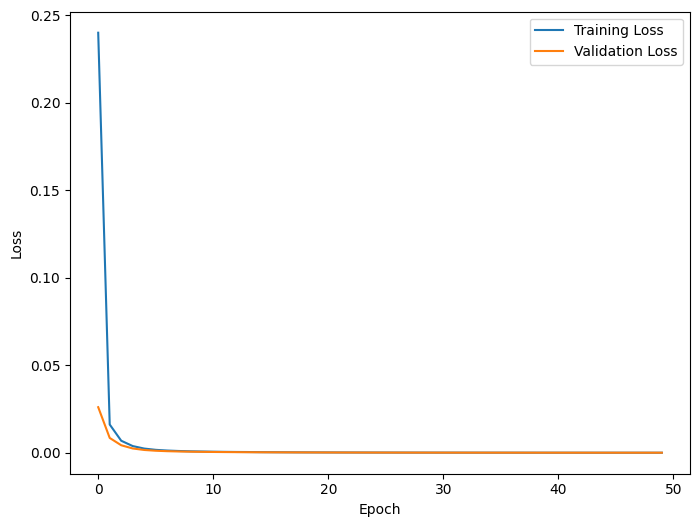

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses[:, 0], label='Training Loss')
ax.plot(losses[:, 1], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
embeddings = model.encoder.embedding.embedding.weight.detach().cpu().numpy()
embedding_mapper = {
    decoder[idx]: embedding for idx, embedding in enumerate(embeddings)
}
embedding_mapper.keys()

dict_keys(['<SOS>', '<EOS>', '<PAD>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'S', 'T', 'V', 'Y', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'g', 'i', 'l', 'n', 'o', 'r', 's', 't', 'u', 'y'])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embeddings)

keys = [
    'A', 'B', 'C', 'D', 'F',
    'G', 'H', 'I', 'K', 'L',
    'M', 'N', 'O', 'P', 'S',
    'T', 'V', 'Y', 'Z', 'a',
    'b', 'c', 'd', 'e', 'g',
    'i', 'l', 'n', 'o', 'r',
    's', 't', 'u', 'y'
]

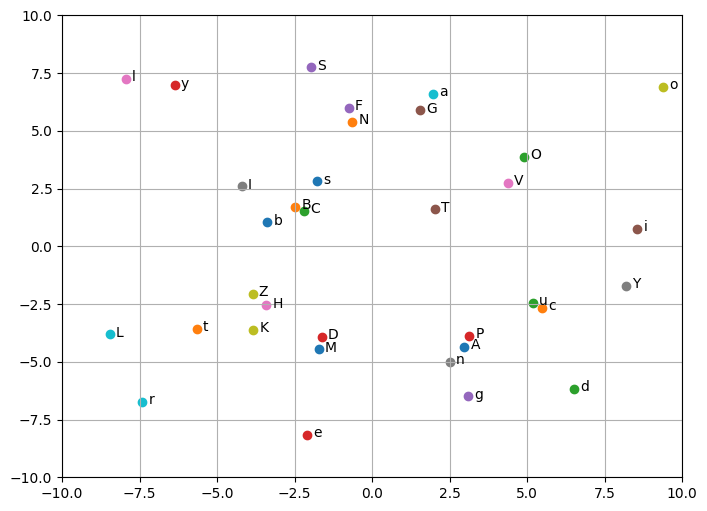

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
for idx, embedding in enumerate(embeddings):
    ax.scatter(embedding_pca[idx, 0], embedding_pca[idx, 1])
    ax.annotate(
        keys[idx],
        (embedding_pca[idx, 0] + 0.2, embedding_pca[idx, 1] - 0.1)
    )
ax.set(
    xlim=[-10, 10],
    ylim=[-10, 10]
)
plt.grid(True)
plt.show()

In [ ]:
path = '/content/drive/MyDrive/MolecularEmbeddings/model_weights.pth'
torch.save(model.state_dict(), path)

In [ ]:
torch.load(path, weights_only=False)

OrderedDict([('encoder.embedding.embedding.weight',
              tensor([[-1.1832,  0.1941, -1.7937,  ..., -0.0384,  0.0132, -0.3539],
                      [-1.7930,  1.2816, -1.1092,  ...,  0.0598, -0.2592, -0.2731],
                      [ 0.7384,  0.7964, -0.2478,  ...,  1.0042,  0.6775, -1.0293],
                      ...,
                      [-0.6941, -0.1312,  0.8333,  ...,  0.0235, -0.1194, -0.6499],
                      [ 0.9470,  1.0532, -1.3870,  ..., -0.2866,  0.4772,  0.7806],
                      [ 1.0564,  1.6610, -1.3804,  ...,  1.4516, -0.2108,  0.8416]],
                     device='cuda:0')),
             ('encoder.positional_encoding.pe',
              tensor([[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
                      [ 0.8415,  0.5403,  0.8317,  ...,  0.9999,  0.0102,  0.9999],
                      [ 0.9093, -0.4161,  0.9236,  ...,  0.9998,  0.0204,  0.9998],
                      ...,
                      [ 0.9906, -0.1368,  0.9424,